In [1]:
from torch import device
from torch.cuda import is_available, device_count

# ---------------------
# General parameters
# ---------------------
SEED: int = 42
NUM_WORKERS: int = 4 * device_count()
INPUT_PATH: str = '/Users/tachamae/Downloads/Thesis/HAM10000'
OUTPUT_PATH: str = '/Users/tachamae/Downloads/Thesis/CDCGAN_Modified_Tanh_Results'
MODELS_PATH: str = '/Users/tachamae/Downloads/Thesis/CDCGAN_Modified_Tanh_Results'
DEVICE = device("cuda" if is_available() else "cpu")  # (GPU if available)

# ---------------------
# Data parameters
# ---------------------
IMAGE_SIZE: int = 64  # 128
assert IMAGE_SIZE in (64, 128), "Other IMAGE_SIZE require custom architectures"
LABEL_TO_CLASS: dict = {
    'akiec': 0,
    'bcc': 1,
    'bkl': 2,
    'df': 3,
    'mel': 4,
    'nv': 5,
    'vasc': 6,
}
CLASS_TO_LABEL: dict = {_v: _k for _k, _v in LABEL_TO_CLASS.items()}
NUM_CLASSES: int = len(LABEL_TO_CLASS)

# ---------------------
# Training parameters
# ---------------------
BATCH_SIZE: int = 128 if IMAGE_SIZE == 64 else 32
NUM_EPOCHS: int = 200

# ---------------------
# Hyperparameters
# ---------------------
LEARNING_RATE: float = 0.0002
BETA_1: float = 0.5

nz: int = 128  # length of latent vector
ngf: int = 128  # depth of feature maps carried through the generator.
ndf: int = 64  # depth of feature maps propagated through the discriminator
# ngpu: int = 1
nc: int = 3  # number of color channels (for color images = 3)
# niter: int = NUM_EPOCHS BATCH_SIZE  # 300
n_dnn: int = 32  # number of output features of the label's linear layer

In [2]:
import os
import pandas as pd
from PIL import Image
from torch import zeros, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from typing import Tuple
from torch import Generator as _DataGenerator


class HAM10000Dataset(Dataset):
    def __init__(self, root_dir: str = INPUT_PATH,
                 metadata_file: str = 'HAM10000_metadata.csv',
                 data_transforms: transforms = None) -> None:
        self.root_dir = root_dir
        self.metadata: pd.DataFrame = self._load_metadata(metadata_file)
        self.transforms = _get_data_transforms() \
            if data_transforms is None else data_transforms

    def __len__(self) -> int:
        return len(self.metadata)

    def __getitem__(self, idx) -> Tuple[Tensor, Tensor]:
        _image_id: str = self.metadata.iloc[idx]['image_id']
        _image_path: str = self._find_image_path(_image_id)

        _image: Image = Image.open(_image_path).convert('RGB')
        _image = self.transforms(_image)

        _label_ind: int = LABEL_TO_CLASS[self.metadata.iloc[idx]['dx']]
        # one-hot encoding
        _label: Tensor = zeros(NUM_CLASSES)
        _label[_label_ind] = 1

        return _image, _label

    def _find_image_path(self, image_id) -> str:
        for folder in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
            image_path = os.path.join(self.root_dir, folder, f"{image_id}.jpg")
            if os.path.exists(image_path):
                return image_path
        raise FileNotFoundError(f"Image {image_id} not found in any folder!")

    def _load_metadata(self, metadata_file: str) -> pd.DataFrame:
        _df = pd.read_csv(os.path.join(self.root_dir, metadata_file))
        _df['age'] = _df['age'].astype(int, errors='ignore')
        return _df


def _get_data_transforms() -> transforms.Compose:
    _mean, _std = 0, 1
    return transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize((_mean, _mean, _mean), (_std, _std, _std)),
        ]
    )


def get_data_loaders() -> Tuple[DataLoader, ...]:
    # load and split the data
    dataset = HAM10000Dataset()
    _train, _val, _test = random_split(
        dataset, [.6, .2, .2],
        generator=_DataGenerator().manual_seed(SEED))

    # ingest torch datasets data into torch dataloader
    train_loader = DataLoader(
        dataset=_train, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS)
    train_loader_at_eval = DataLoader(
        dataset=_train, batch_size=2 * BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS)
    val_loader = DataLoader(
        dataset=_val, batch_size=2 * BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS)
    test_loader = DataLoader(
        dataset=_test, batch_size=2 * BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS)

    return train_loader, train_loader_at_eval, val_loader, test_loader

In [3]:
import torch
import torch.nn as nn
#######################################################################
# (Conditional) DCGAN: cDCGAN
#######################################################################

# IMAGE_SIZE = 64 # ###################################################

class Generator64(nn.Module):
    def __init__(self):
        assert IMAGE_SIZE == 64, \
            f"This architecture is not suitable for IMAGE_SIZE = {IMAGE_SIZE}"
        super(Generator64, self).__init__()

        self.y_label = nn.Sequential(
            nn.Linear(NUM_CLASSES, n_dnn),  # 7, 1000
            nn.ReLU(True))

        self.main = nn.Sequential(
            nn.ConvTranspose2d(n_dnn + nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh())
            # state size. (nc) x 64 x 64

    def forward(self, z, y):
        y = self.y_label(y)
        inp = torch.cat([z, y], 1)
        inp = inp.view(-1, n_dnn + nz, 1, 1)
        output = self.main(inp)
        return output


class Discriminator64(nn.Module):
    def __init__(self):
        assert IMAGE_SIZE == 64, \
            f"This architecture is not suitable for IMAGE_SIZE = {IMAGE_SIZE}"
        super(Discriminator64, self).__init__()
        # self.ngpu = _ngpu
        self.y_label = nn.Sequential(
            nn.Linear(NUM_CLASSES, 32),
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc + 32, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        batch_size = x.size(0)
        y = self.y_label(y)
        y = y.view(batch_size, 32, 1, 1)
        y = y.repeat(1, 1, 64, 64)
        inp = torch.cat([x, y], 1)
        output = self.main(inp)
    
        return output.view(-1, 1).squeeze(1)

In [4]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Assuming Generator64 and Discriminator64 are already defined and initialized
gen = Generator64()
disc = Discriminator64()

gen_total_params, gen_trainable_params = count_parameters(gen)
disc_total_params, disc_trainable_params = count_parameters(disc)

print(f"Generator Total Parameters: {gen_total_params}, Trainable Parameters: {gen_trainable_params}")
print(f"Discriminator Total Parameters: {disc_total_params}, Trainable Parameters: {disc_trainable_params}")

Generator Total Parameters: 13641728, Trainable Parameters: 13641728
Discriminator Total Parameters: 2798592, Trainable Parameters: 2798592


In [5]:
print(gen)

Generator64(
  (y_label): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(160, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=Tr

In [6]:
print(disc)

Discriminator64(
  (y_label): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(35, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11):

In [7]:
from colorama import Fore, Back, Style, init
import logging
from sys import stdout


# Prepare the colored formatter
init(autoreset=True)
terminal_colors = {"DEBUG": Fore.GREEN,  # "INFO": Fore.CYAN,
                   "WARNING": Fore.YELLOW, "ERROR": Fore.RED,
                   "CRITICAL": Fore.WHITE + Back.RED + Style.BRIGHT}
html_colors = {"DEBUG": 'BLUE',  # "INFO": Fore.CYAN,
               "WARNING": 'YELLOW', "ERROR": "ORANGE",
               "CRITICAL": "RED"}


class SingletonMeta(type):
    """
    Implementation of the Singleton pattern as Python metaclass.
    """
    _instances = {}

    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(
                SingletonMeta, cls).__call__(*args, **kwargs)

        return cls._instances[cls]
        # else:
        # to run __init__ every time the class is called...
        #     cls._instances[cls].__init__(*args, **kwargs)


class ColoredFormatter(logging.Formatter):
    def format(self, record):
        msg = super().format(record)
        if record.levelname in terminal_colors:
            msg = terminal_colors[record.levelname] + msg + \
                  Fore.RESET + Back.RESET + Style.RESET_ALL
        return msg


class Logger(logging.Logger, metaclass=SingletonMeta):
    def __init__(self):
        fmt: str = "%(asctime)s %(levelname)8s >> %(message)s"
        # fmt: str = "%(asctime)s %(levelname)8s: %(name)18s >> %(message)s"
        date_format: str = "%m/%d/%Y %I:%M:%S %p"
        colored_formatter = ColoredFormatter(fmt, datefmt=date_format)
        bw_formatter = logging.Formatter(fmt, datefmt=date_format)

        # now we set the main / base logger called 'parent'
        super().__init__('hamgan-summary', logging.DEBUG)
        handler = logging.StreamHandler(stdout)
        handler.setLevel(logging.DEBUG)
        handler.setFormatter(colored_formatter)
        self.addHandler(handler)

    def _log(self, level: int, msg: object, args, **kwargs) -> None:
        """
        Log a message at a given level and always including the module's name
        from where the call was made.
        """
        logging.Logger.__dict__['_log'](self, level, msg, args, **kwargs)

In [8]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn as nn, optim as optim
from torch import Tensor, device
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from typing import List, Tuple

_DEVICE = DEVICE
Generator = Generator64
Discriminator = Discriminator64


def seed_everything():
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True


def __generate_random_noise() -> Tensor:
    return torch.randn(BATCH_SIZE, nz, device=_DEVICE)


def __generate_random_labels() -> Tensor:
    label = torch.zeros(BATCH_SIZE, NUM_CLASSES, device=_DEVICE)
    for i in range(BATCH_SIZE):
        x = np.random.randint(0, NUM_CLASSES)
        label[i][x] = 1
    return label


# random seeds for reproducibility
seed_everything()
# noise and labels from which images will be generated at checkpoint
_checkpoint_noise = __generate_random_noise()
_checkpoint_labels = __generate_random_labels()

# we create directory to save the generated images and the trained models
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
logger = Logger()


def train_gan(
        data_loader: DataLoader, use_cpu: bool = False,
        save_best_model: bool = True, save_generated_images: bool = True,
        verbose: bool = False, _freq: int = 5) -> Tuple[Generator, Discriminator]:
    DEVICE = device('cpu') if use_cpu else _DEVICE
    # initialize (with weights) generator and discriminator
    net_g = Generator().to(DEVICE)
    net_g.apply(weights_init)
    net_d = Discriminator().to(DEVICE)
    net_d.apply(weights_init)

    # loss function and optimizers
    criterion = nn.BCELoss()  # we are simply detecting whether it's real/fake

    real_label = float(1)
    fake_label = float(0)

    # setup optimizer
    optimizer_d = optim.Adam(
        net_d.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
    optimizer_g = optim.Adam(
        net_g.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
    d_error_epoch = []
    g_error_epoch = []

    for epoch in range(NUM_EPOCHS):
        # we will start iterating each batch element
        d_error_iter = 0
        g_error_iter = 0
        for i, data in enumerate(data_loader, 0):
            # DISCRIMINATOR
            # train with real
            net_d.zero_grad()
            real_cpu = data[0].to(DEVICE)
            batch_size = real_cpu.size(0)
            pathology_one_hot = data[1].to(DEVICE)
            label = torch.full((batch_size, ), real_label, device=DEVICE)

            output = net_d(real_cpu, pathology_one_hot)
            err_d_real = criterion(output, label)
            err_d_real.backward()
            # D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, device=DEVICE)
            fake = net_g(noise, pathology_one_hot)
            label.fill_(fake_label)
            output = net_d(fake.detach(), pathology_one_hot)
            err_d_fake = criterion(output, label)
            err_d_fake.backward()
            # D_G_z1 = output.mean().item()
            err_d = err_d_real + err_d_fake
            d_error_iter += err_d.item()
            optimizer_d.step()

            # GENERATOR
            net_g.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = net_d(fake, pathology_one_hot)
            err_g = criterion(output, label)
            g_error_iter += err_g.item()
            err_g.backward()
            # D_G_z2 = output.mean().item()
            optimizer_g.step()

            if (i + 1) % (BATCH_SIZE // 4) == 0 and verbose:
                # we print the losses
                _counter = f"Epoch [{epoch}/{NUM_EPOCHS}]" \
                           f"[{i}/{len(data_loader)}]"
                logger.debug(f"{_counter} --- Loss G: {err_g.item()}")
                logger.debug(f"{_counter} --- Loss D: {err_d.item()}")

        if (epoch + 1) % _freq == 0:
            # we save generated images
            with torch.no_grad():
                if save_generated_images:
                    logger.debug(
                        "CHECKPOINT: saving some generated images "
                        f"at '{OUTPUT_PATH}' directory")
                    checkpoint_images = net_g(
                        _checkpoint_noise, _checkpoint_labels)
                    # we re-scale generated images to [0, 1] and save them
                    save_image((checkpoint_images + 1) / 2,
                               os.path.join(OUTPUT_PATH,
                                            f"epoch_{epoch + 1}.png"),
                               nrow=8, normalize=True)

            # save models as checkpoint
            if save_best_model:
                logger.debug("CHECKPOINT: saving the trained"
                             f" models at '{MODELS_PATH}' directory")
                torch.save(net_g.state_dict(),
                           os.path.join(MODELS_PATH, "generator.pth"))
                torch.save(net_d.state_dict(),
                           os.path.join(MODELS_PATH, "discriminator.pth"))

        # accumulate error for each epoch
        d_error_epoch.append(d_error_iter)
        g_error_epoch.append(g_error_iter)

    _plot_losses(g_error_epoch, d_error_epoch)

    # save the trained generator
    torch.save(net_g.state_dict(),
               os.path.join(MODELS_PATH, "generator.pth"))
    # as well as the trained discriminator
    torch.save(net_d.state_dict(),
               os.path.join(MODELS_PATH, "discriminator.pth"))

    return net_g, net_d


def weights_init(m) -> callable:
    class_name = m.__class__.__name__
    if class_name.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def _plot_losses(g_losses: List[float], d_losses: List[float],
                 _show: bool = False) -> None:
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(g_losses, label="Generator")
    plt.plot(d_losses, label="Discriminator")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join('img', 'losses.png'), dpi=200)
    if _show:
        plt.show()
    plt.close()


def _labels_to_tensor(labels: Tuple[str]) -> torch.Tensor:
    return torch.tensor(
        tuple(LABEL_TO_CLASS[_l] for _l in labels))

In [9]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Tuple


labels_as_titles = {
        'akiec': 'Actinic keratoses',
        'bcc': 'Basal cell carcinoma',
        'bkl': 'Benign keratosis-like',
        'df': 'Dermatofibroma',
        'mel': 'Melanoma',
        'nv': 'Melanocytic nevi',
        'vasc': 'Vascular lesions',
    }


def plot_real_images(_show: bool = False) -> None:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    _dataset = HAM10000Dataset()

    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(_dataset), size=(1,)).item()
        img, label = _dataset[sample_idx]
        label = np.argmax(label)

        figure.add_subplot(rows, cols, i)
        plt.title(labels_as_titles[CLASS_TO_LABEL[label]])
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    plt.tight_layout(pad=1.02)
    plt.savefig(os.path.join('img', 'original_samples.png'), dpi=200)
    if _show:
        plt.show()
    plt.close()


def plot_fake_images(
        generator, n_images: int = 9, _show: bool = False) -> None:
    cols, rows = 3, 3
    fig, axs = plt.subplots(rows, cols, sharex='all')
    axs = axs.flatten()

    gen_z, label, _label_names = __generate_random_inputs(n_images)
    gen_images = generator(gen_z, label)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)

    for i in range(9):
        axs[i].set_title(_label_names[i])
        axs[i].set_axis_off()
        axs[i].imshow(images[i])
    plt.tight_layout(pad=1.04)
    plt.savefig(os.path.join('img', 'fake_samples.png'), dpi=200)
    if _show:
        plt.show()
    plt.close()


def __generate_random_inputs(n_images: int) \
        -> Tuple[torch.Tensor, torch.Tensor, list]:
    gen_z = torch.randn(n_images, nz, device=DEVICE)
    label = torch.zeros(n_images, NUM_CLASSES, device=DEVICE)
    _label_names = []
    for i in range(n_images):
        x = np.random.randint(0, NUM_CLASSES)
        label[i][x] = 1
        _label_names.append(labels_as_titles[CLASS_TO_LABEL[x]])
    return gen_z, label, _label_names

03/12/2024 09:15:58 PM     INFO >> Getting data loader
03/12/2024 09:15:58 PM     INFO >> Initializing generator & discriminator
03/12/2024 09:20:38 PM    DEBUG >> Epoch [0/200][31/47] --- Loss G: 3.008781671524048
03/12/2024 09:20:38 PM    DEBUG >> Epoch [0/200][31/47] --- Loss D: 2.453791856765747
03/12/2024 09:26:57 PM    DEBUG >> Epoch [1/200][31/47] --- Loss G: 2.548203706741333
03/12/2024 09:26:57 PM    DEBUG >> Epoch [1/200][31/47] --- Loss D: 1.6791160106658936
03/12/2024 09:33:03 PM    DEBUG >> Epoch [2/200][31/47] --- Loss G: 3.4940085411071777
03/12/2024 09:33:03 PM    DEBUG >> Epoch [2/200][31/47] --- Loss D: 0.7128100991249084
03/12/2024 09:39:07 PM    DEBUG >> Epoch [3/200][31/47] --- Loss G: 1.8923461437225342
03/12/2024 09:39:07 PM    DEBUG >> Epoch [3/200][31/47] --- Loss D: 1.2392507791519165
03/12/2024 09:45:13 PM    DEBUG >> Epoch [4/200][31/47] --- Loss G: 2.4781596660614014
03/12/2024 09:45:13 PM    DEBUG >> Epoch [4/200][31/47] --- Loss D: 0.5977907180786133
03/1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


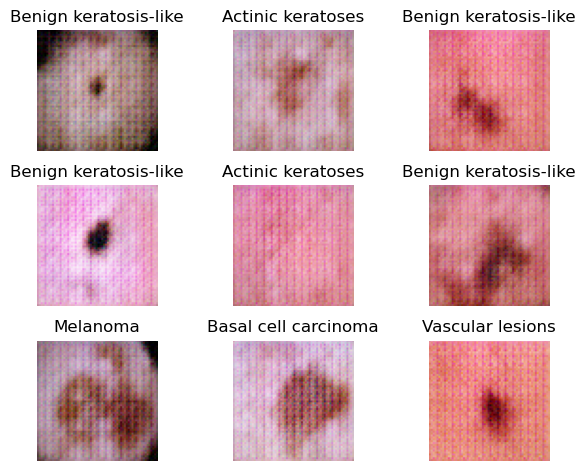

In [10]:
import os
import argparse
from torch import load, device

logger = Logger()


def main(use_cpu: bool = False, load_model: bool = False,
         save_best_model: bool = False, save_generated_images: bool = False,
         verbose: bool = False) -> None:
    if load_model:
        logger.info("Loading already trained and serialized generator model")
        generator = Generator().to(device('cpu') if use_cpu else DEVICE)
        generator.load_state_dict(load(
            os.path.join(MODELS_PATH, "generator.pth")))
        plot_fake_images(generator, _show=False)
        return

    # we obtain dataloader (`HAM10000Dataset` initialized under the hood)
    logger.info("Getting data loader")
    train_loader, _, _, _ = get_data_loaders()
    logger.info("Initializing generator & discriminator")

    generator, discriminator = train_gan(
        train_loader, use_cpu=use_cpu, save_best_model=save_best_model,
        save_generated_images=save_generated_images, verbose=verbose)
    logger.info("Visualizing some generated images")
    plot_fake_images(generator, _show=True)


main(use_cpu=True,save_best_model=True,save_generated_images=True,verbose=True)

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt


def custom_plot_fake_images(generator, n_images: int = 9, specific_class: int = None, _show: bool = False, count = 0) -> None:
    gen_z, label, _label_names = __generate_random_inputs(n_images, specific_class)
    gen_images = generator(gen_z, label)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    
    # Ensure the output directory exists
    output_dir = 'generated_images_v3_tanh'
    os.makedirs(output_dir, exist_ok=True)

    for i in range(len(images)):
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(images[i])
        
        # Save each image to a separate file
        class_name = _label_names[i].replace(" ", "_")  # Replace spaces with underscores for file naming
        file_name = f"{class_name}_{count}.png"
        plt.savefig(os.path.join(output_dir, file_name), dpi=200, bbox_inches='tight', pad_inches=0)
        
        if _show:
            plt.show()
        plt.close()

        
def __generate_random_inputs(n_images: int, specific_class: int = None) -> Tuple[torch.Tensor, torch.Tensor, list]:
    gen_z = torch.randn(n_images, nz, device=DEVICE)
    label = torch.zeros(n_images, NUM_CLASSES, device=DEVICE)
    _label_names = []
    
    if specific_class is not None:
        # Generate images for a specific class
        for i in range(n_images):
            label[i][specific_class] = 1
            _label_names.append(labels_as_titles[CLASS_TO_LABEL[specific_class]])
    else:
        # Generate images for all classes, cycling through them
        for i in range(n_images):
            class_index = i % NUM_CLASSES  # Cycle through classes
            label[i][class_index] = 1
            _label_names.append(labels_as_titles[CLASS_TO_LABEL[class_index]])
    
    return gen_z, label, _label_names

model = Generator64()
state_dict = torch.load(os.path.join(MODELS_PATH, "generator.pth"))
model.load_state_dict(state_dict)

#custom_plot_fake_images(model, n_images=20, specific_class=6, _show=False)

num_images = 6590

# To generate images for all classes, call the function without specifying specific_class:
for count in range(num_images):
    custom_plot_fake_images(model, n_images=NUM_CLASSES, _show=False, count=count)
    
print("Images successfully generated.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i